In [1]:
import pandas as pd
import numpy as np

#Choose the country: SWE, ESP, FIN, DNK, CHL, COL, IDN, ISR, MEX, NOR
country = 'SWE'
#Choose the percentage of testing data amoung the total dataset
Percent_test_data = 0.25

full_data = pd.read_csv('data/full/'+country+'.csv', dtype={'Value': np.float64, 'index_All_sentiment': np.float64, 'index_All_sentiment_(w/o_pos_and_neg)': np.float64, 'index_Crisis_sentiment': np.float64, 'index_Fear_sentiment': np.float64, 'index_Opinion_sentiment': np.float64, 'index_Positive_sentiment': np.float64, 'index_Risk_sentiment': np.float64}, usecols = ['time','index_All_sentiment', 'index_All_sentiment_(w/o_pos_and_neg)', 'index_Crisis_sentiment', 'index_Fear_sentiment', 'index_Positive_sentiment', 'Value'], parse_dates=True, date_parser=lambda date: pd.datetime.strptime(date, '%Y-%m'))

In [2]:
from sklearn.model_selection import train_test_split
#delete the lines with at least one NaN
full_data = full_data.dropna()

# Separate Value from other features
output_df=full_data['Value'].copy()
input_df=full_data.drop(['Value'],axis=1) 
 
#Compute the number of sample for each set
lenght = len(output_df)
nb_test = int(lenght*Percent_test_data)

#Splitting traing/test
X_train = input_df[0:len(input_df)-nb_test]
X_test = input_df[-nb_test:-1]
Y_train = output_df[0:len(input_df)-nb_test]
Y_test = output_df[-nb_test:-1]

In [3]:
# take the first year of the data
init = full_data['time'][0].split('-')
init=[int(j) for j in init]
init = init[0]
n=len(X_train)

#convert a date list into a numerical array
def date_to_num_train(df):
    var=[]

    for i in range(len(df)):
        # split the date into [year, mouth]
        var.append(df['time'][i].split('-'))
        # converting string into integer
        var[i]=[int(j) for j in var[i]]
        # creating numerical dates
        df.loc[i, 'time']= (var[i][0]+12*(var[i][0]-init)+var[i][1]-init)

    return df

def date_to_num_test(df):
    var=[]

    for i in range(len(df)):
        # split the date into [year, mouth]
        var.append(df['time'][i+n].split('-'))
        # converting string into integer
        var[i]=[int(j) for j in var[i]]
        # creating numerical dates
        df.loc[i+n, 'time']= (var[i][0]+12*(var[i][0]-init)+var[i][1]-init)

    return df


In [4]:
x_train=date_to_num_train(X_train)
#print('***train***')
#print(x_train)

x_test=date_to_num_test(X_test)
#print('***test***')
#print((x_test['time'][0]).type())

In [5]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures

def prepare_data(df):
    variable = df[['time','index_All_sentiment', 'index_All_sentiment_(w/o_pos_and_neg)', 'index_Crisis_sentiment', 'index_Fear_sentiment', 'index_Positive_sentiment']].copy()
    variable=variable.apply(lambda x: pd.to_numeric(x, errors='ignore'))
    variable_array = np.array(variable)
    variable_pol = PolynomialFeatures(1)
    variable_pol = variable_pol.fit_transform(variable_array)

    return variable_pol

input_train1 = prepare_data(x_train)
input_test1 = prepare_data(x_test)
output_train1 = np.array(Y_train)
output_test1 = np.array(Y_test)

In [6]:
class my_linear_regression:
    def __init__(self) : # initialize constructor for the object to assign the object its properties
        self.X_train = []
        self.y_train = []
        self.weights = []
        
    def fit(self, X, y) :
        self.X_train = X
        self.y_train = y
        #print('first term: ') 
        #print(X.T@X)
        #print('len X: ' + str(len(X)))
        #print('len y: ' + str(len(y)))
        #print(len((X.T@X)[0]))
        #print(X.T@y)
        #print(len(X.T@y))
        #print(len((X.T@y)[0]))
        self.weights = np.linalg.solve(X.T@X,X.T@y)
    
    def predict(self,x_test,y_test) : # method of the object that can be used
        self.y_hat=np.sum(x_test*self.weights,axis=1)
        self.MSE= (np.sum((y_test-self.y_hat)**2))/len(y_test)
        
        return self.y_hat, self.MSE

In [13]:
model_1 = my_linear_regression()
model_1.fit(input_train1, output_train1)
model_1.predict(input_test1, output_test1)

features = ['w0', 'time','index_All_sentiment', 'index_All_sentiment_(w/o_pos_and_neg)', 'index_Crisis_sentiment', 'index_Fear_sentiment', 'index_Positive_sentiment']

MSE_1_train = model_1.MSE
#print("weight[0] : {}, weight[1:] : {}".format(model_1.weights[0], model_1.weights[1:]))
print("MSE : {}".format(MSE_1_train))
for i in range (len(model_1.weights)):
    print('weight['+str(i)+'] = '+ str(model_1.weights[i])+', for ' + features[i])

MSE : 11.406643132778429
weight[0] = 14.154308090047335, for w0
weight[1] = -0.039306186597459596, for time
weight[2] = -0.11991716311770653, for index_All_sentiment
weight[3] = -0.08166811081558574, for index_All_sentiment_(w/o_pos_and_neg)
weight[4] = 3.560938018843149, for index_Crisis_sentiment
weight[5] = 0.728505789976028, for index_Fear_sentiment
weight[6] = 0.579861529373606, for index_Positive_sentiment


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E5068D0E20>,
      dtype=object)

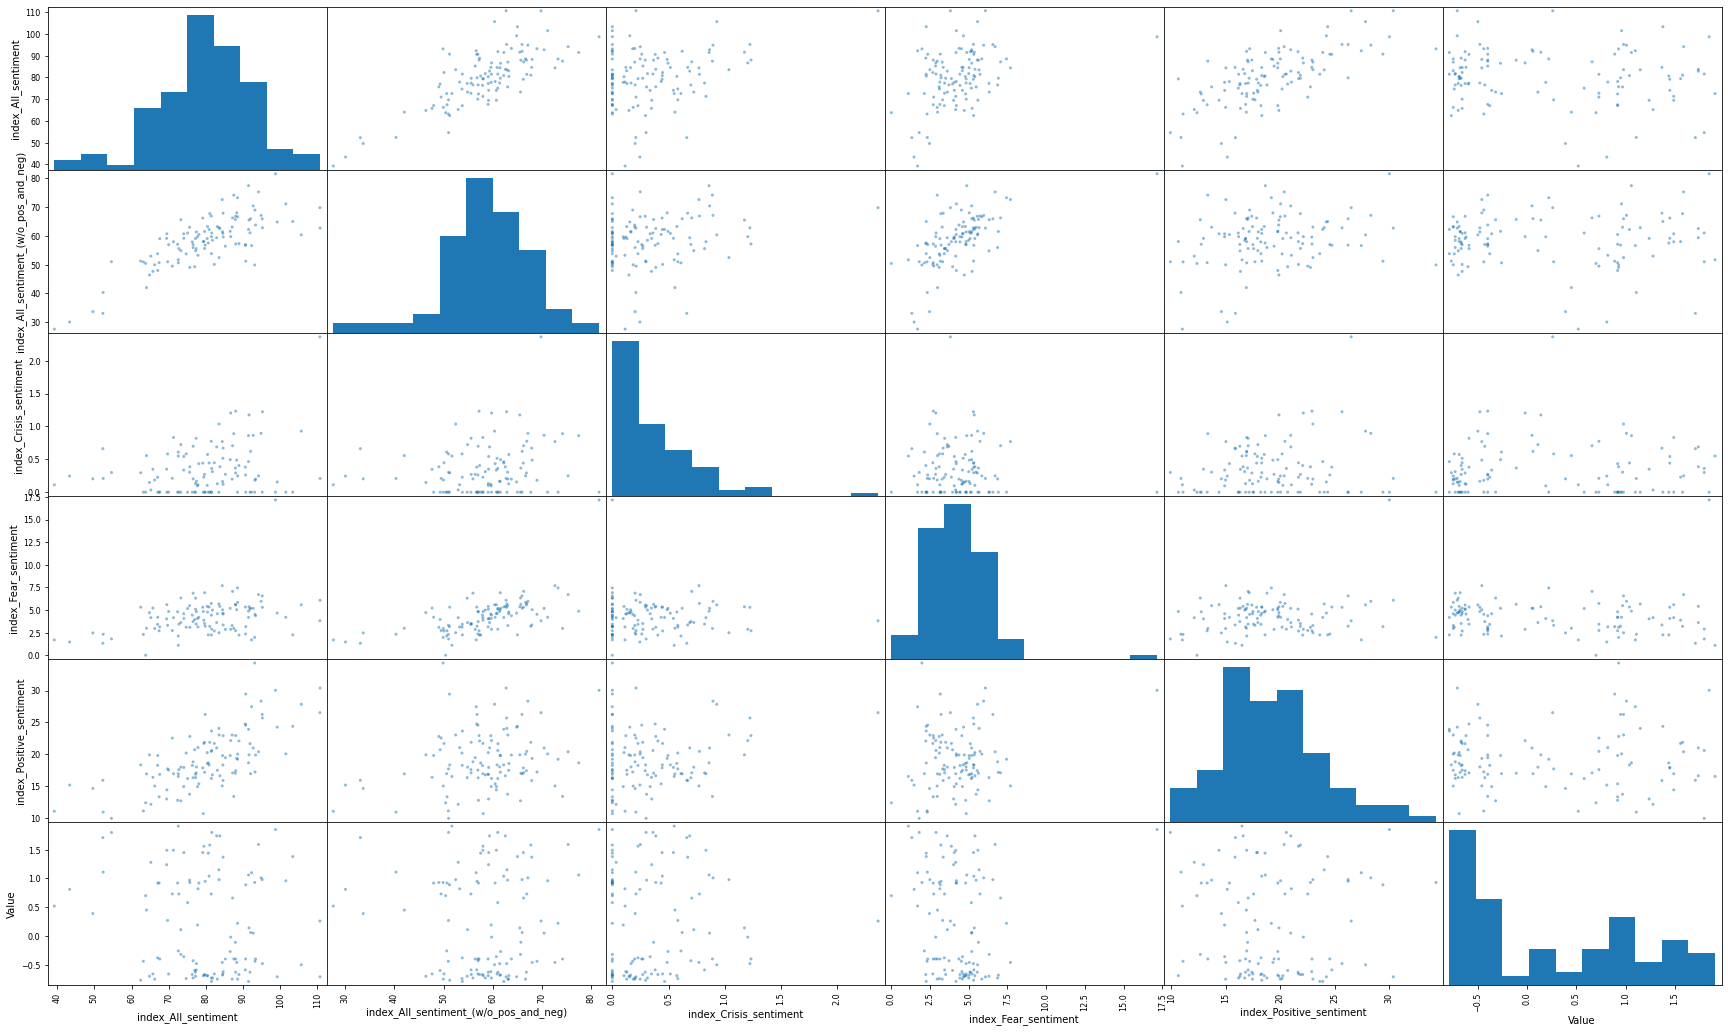

In [8]:
from pandas.plotting import scatter_matrix
to_plot=pd.concat([X_test,Y_test],axis=1)
scatter_matrix(to_plot, figsize=(30,18))

In [9]:
rolling_index = 10

# creating a smoother prediction function
y_hat_series = pd.Series(model_1.y_hat)
smoother_y_hat = y_hat_series.rolling(rolling_index).mean()

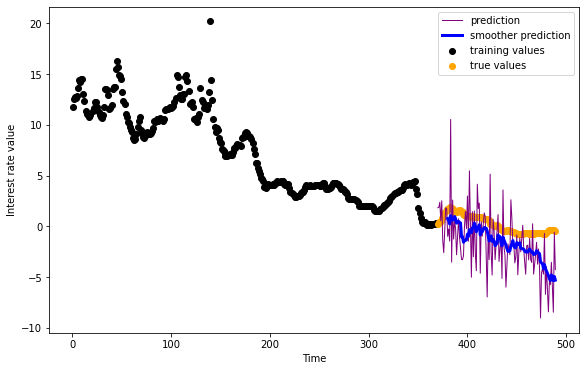

In [12]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [9.5, 6]
#training values plot
plt.scatter(input_train1[:,1], output_train1, color='black')
#truth plot
plt.scatter(input_test1[:,1], output_test1, color='orange')
#prediction plot
plt.plot(input_test1[:,1], model_1.y_hat,  color='purple', linewidth=1)
#smoother prediction plot
plt.plot(input_test1[:,1], smoother_y_hat,  color='blue', linewidth=3)

plt.legend(['prediction', 'smoother prediction', 'training values', 'true values'])
plt.xlabel('Time')
plt.ylabel('Interest rate value')
plt.show()